In [ ]:
import os
import random
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F
import dill as pickle
import numpy as np
import torch
from torch.distributions import Categorical
from tqdm import tqdm

# from UAV_new_0415.test import agent
from environment import GridWorld #Change the environment here
from subrl.utils.network import append_state
from subrl.utils.network import policy as agent_net
from visualization import Visu
from subpo import calculate_submodular_reward, compute_subpo_advantages

workspace = "NM"

In [53]:

params = {
    "env": {
        "start": 1,
        "step_size": 0.1,
        "shape": {"x": 7, "y": 14},
        "horizon": 40,
        "node_weight": "constant",
        "disc_size": "small",
        "n_players": 3,
        "Cx_lengthscale": 2,
        "Cx_noise": 0.001,
        "Fx_lengthscale": 1,
        "Fx_noise": 0.001,
        "Cx_beta": 1.5,
        "Fx_beta": 1.5,
        "generate": False,
        "env_file_name": "env_data.pkl",
        "cov_module": "Matern",
        "stochasticity": 0.0,
        "domains": "two_room"
    },
    "alg": {
        "gamma": 1,
        "type": "NM",
        "ent_coef": 0.03,
        "epochs": 500,
        "lr": 0.01
    },
    "common": {
        "a": 1,
        "subgrad": "greedy",
        "grad": "pytorch",
        "algo": "both",
        "init": "deterministic",
        "batch_size": 300
    },
    "visu": {
        "wb": "disabled",
        "a": 1
    }
}
env_load_path = workspace + \
    "/environments/" + params["env"]["node_weight"]+ "/env_1" 

params['env']['num'] = 1
# start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="code-" + params["env"]["node_weight"],
#     mode=params["visu"]["wb"],
#     config=params
# )

epochs = params["alg"]["epochs"]

H = params["env"]["horizon"]
MAX_Ret = 2*(H+1)
if params["env"]["disc_size"] == "large":
    MAX_Ret = 3*(H+2)
    
env = GridWorld(
    env_params=params["env"], common_params=params["common"], visu_params=params["visu"], env_file_path=env_load_path)
node_size = params["env"]["shape"]['x']*params["env"]["shape"]['y']
# TransitionMatrix = torch.zeros(node_size, node_size)

if params["env"]["node_weight"] == "entropy" or params["env"]["node_weight"] == "steiner_covering" or params["env"]["node_weight"] == "GP": 
    a_file = open(env_load_path +".pkl", "rb")
    data = pickle.load(a_file)
    a_file.close()

if params["env"]["node_weight"] == "entropy":
    env.cov = data
if params["env"]["node_weight"] == "steiner_covering":
    env.items_loc = data
if params["env"]["node_weight"] == "GP":
    env.weight = data

visu = Visu(env_params=params["env"])
# plt, fig = visu.stiener_grid( items_loc=env.items_loc, init=34)
# wandb.log({"chart": wandb.Image(fig)})
# plt.close()
# Hori_TransitionMatrix = torch.zeros(node_size*H, node_size*H)
# for node in env.horizon_transition_graph.nodes:
#     connected_edges = env.horizon_transition_graph.edges(node)
#     for u, v in connected_edges:
#         Hori_TransitionMatrix[u[0]*node_size+u[1], v[0]*node_size + v[1]] = 1.0
env.get_horizon_transition_matrix()
# policy = Policy(TransitionMatrix=TransitionMatrix, Hori_TransitionMatrix=Hori_TransitionMatrix, ActionTransitionMatrix=env.Hori_ActionTransitionMatrix[:, :, :, 0],
#                 agent_param=params["agent"], env_param=params["env"])


x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001]


In [54]:
def select_cell_from_archive(archive):
    """
    Select a cell from the archive for exploration.
    Cells with the fewest selection counts are prioritized.
    """
    if not archive:
        return None, None

    # Find the minimum selection count
    min_times_selected = float('inf')
    for cell_id in archive:
        if archive[cell_id]['times_selected'] < min_times_selected:
            min_times_selected = archive[cell_id]['times_selected']
    
    # Find all cells with the minimum selection count
    least_visited_cells = []
    for cell_id in archive:
        if archive[cell_id]['times_selected'] == min_times_selected:
            least_visited_cells.append(cell_id)
            
    #  Randomly select one of these cells
    selected_cell_id = random.choice(least_visited_cells)
    
    return selected_cell_id, archive[selected_cell_id]

def sample_excellent_trajectories(filepath="go_explore_archive_spacetime.pkl", 
                                  method='top_n', 
                                  n=10, 
                                  p=0.1, 
                                  threshold=0):
    """
        Load data from the Go-Explore archive and sample high-quality trajectories based on the specified method.

        Args:
            filepath (str): Path to the .pkl archive file.
            method (str): Sampling method. Options are 'top_n', 'top_p', or 'threshold'.
            n (int): Number of trajectories to sample for the 'top_n' method.
            p (float): Percentage of top trajectories to sample for the 'top_p' method (e.g., 0.1 means top 10%).
            threshold (float): Minimum reward threshold for the 'threshold' method.
        
        Returns:
            list: A list of trajectory dictionaries with high rewards, sorted in descending order of reward.
                  Returns an empty list if the file does not exist or the archive is empty.
    """
    # 1. Check if the file exists and load the data
    if not os.path.exists(filepath):
        print(f"Error: Archive file not found '{filepath}'")
        return []
    
    try:
        with open(filepath, "rb") as f:
            archive = pickle.load(f)
        if not archive:
            print("警告：存檔庫為空。")
            return []
    except Exception as e:
        print(f"讀取文件時出錯: {e}")
        return []

    # 2. 提取所有軌跡數據並按獎勵排序
    # archive.values() 返回的是包含 reward, states, actions 等信息的字典
    all_trajectories_data = list(archive.values())
    
    # 按 'reward' 鍵從高到低排序
    all_trajectories_data.sort(key=lambda x: x['reward'], reverse=True)

    # 3. 根據指定方法進行採樣
    sampled_trajectories = []
    if method == 'top_n':
        # 取獎勵最高的前 N 條
        num_to_sample = min(n, len(all_trajectories_data))
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-N。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的 {len(sampled_trajectories)} 條。")

    elif method == 'top_p':
        # 取獎勵最高的前 P%
        if not (0 < p <= 1):
            print("錯誤：百分比 'p' 必須在 (0, 1] 之間。")
            return []
        num_to_sample = int(len(all_trajectories_data) * p)
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-P。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的前 {p*100:.1f}% ({len(sampled_trajectories)} 條)。")

    elif method == 'threshold':
        # 取獎勵高於指定門檻的所有軌跡
        sampled_trajectories = [data for data in all_trajectories_data if data['reward'] >= threshold]
        print(f"方法: Threshold。從 {len(all_trajectories_data)} 條軌跡中篩選出 {len(sampled_trajectories)} 條獎勵不低於 {threshold} 的軌跡。")
        
    else:
        print(f"錯誤：未知的採樣方法 '{method}'。請使用 'top_n', 'top_p', 或 'threshold'。")

    return sampled_trajectories


In [55]:
# 範例1：獲取獎勵最高的 20 條軌跡
print("--- 範例 1: 採樣 Top 20 ---")
top_20_trajectories = sample_excellent_trajectories(method='top_n', n=11)
if top_20_trajectories:
    print(f"其中最好的一條獎勵為: {top_20_trajectories[0]['reward']}")
    print(f"最差的一條（在這300條中）獎勵為: {top_20_trajectories[-1]['reward']}\n")

# 範例2：獲取獎勵排名前 5% 的軌跡
print("--- 範例 2: 採樣 Top 5% ---")
top_5_percent_trajectories = sample_excellent_trajectories(method='top_p', p=0.05)
if top_5_percent_trajectories:
    # 打印其中一條軌跡的詳細信息以供檢查
    sample_traj_data = top_5_percent_trajectories[0]
    print(f"抽樣檢查最好的一條軌跡：獎勵={sample_traj_data['reward']}, 長度={len(sample_traj_data['states'])}\n")

# 範例3：獲取所有獎勵值大於等於 45 的軌跡
print("--- 範例 3: 採樣獎勵 >= 45 的軌跡 ---")
high_reward_trajectories = sample_excellent_trajectories(method='threshold', threshold=68)
if high_reward_trajectories:
    print(f"所有高分軌跡的平均獎勵為: {np.mean([d['reward'] for d in high_reward_trajectories]):.2f}\n")


--- 範例 1: 採樣 Top 20 ---
方法: Top-N。從 2312 條軌跡中篩選出最好的 11 條。
其中最好的一條獎勵為: 68
最差的一條（在這300條中）獎勵為: 68

--- 範例 2: 採樣 Top 5% ---
方法: Top-P。從 2312 條軌跡中篩選出最好的前 5.0% (115 條)。
抽樣檢查最好的一條軌跡：獎勵=68, 長度=40

--- 範例 3: 採樣獎勵 >= 45 的軌跡 ---
方法: Threshold。從 2312 條軌跡中篩選出 11 條獎勵不低於 68 的軌跡。
所有高分軌跡的平均獎勵為: 68.00



In [56]:
#基于embedding的模仿学习

import torch
import torch.nn.functional as F  # 这里导入 F
import torch.nn as nn

class TemporalStateEncoder(nn.Module):
    def __init__(self, num_states=98, embed_dim=16, hidden_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(num_states, embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim)

    def forward(self, state_seq):
        indices = [i for i in state_seq if i >= 0]
        if not indices:
            return torch.zeros(self.lstm.hidden_size)

        input_emb = self.embedding(torch.tensor(indices).long()).unsqueeze(1)  # [T, 1, D]
        _, (h_n, _) = self.lstm(input_emb)
        return h_n.squeeze(0).squeeze(0)  # [hidden_dim]

def encode_temporal_state(state_seq, embed_table):
    """
    输入: state_seq: Tensor[H]，如 [34, 33, -1, ..., -1]
    输出: Tensor[embed_dim]，嵌入向量
    """
    indices = [i for i in state_seq if i >= 0]  # 去除 -1
    if not indices:
        return torch.zeros(embed_table.embedding_dim)
    indices_tensor = torch.tensor(indices, dtype=torch.long)
    embeds = embed_table(indices_tensor)
    return embeds.mean(dim=0)
def encode_temporal_state2(state_seq, encoder):
    return encoder(state_seq)

def submodular_selector_temporal(trajectories, embed_table,temporal_encoder, budget=50, lambda_div=0.5, per_traj_limit=True):
    """
    改进版子模选择器：
    - 使用欧几里得距离作为 diversity 惩罚项
    - 可选启用：每条轨迹最多选一个状态（保证轨迹多样性）
    """
    state_vectors = []
    action_labels = []
    traj_ids = []

    for traj_id, traj in enumerate(trajectories):
        states = [int(s.item()) for s in traj['states']]
        actions = traj['actions']
        for t, action in enumerate(actions):
            temporal_state = [-1]*40
            for h in range(t+1):
                temporal_state[h] = states[h]
            temporal_tensor = torch.tensor(temporal_state, dtype=torch.long)
            # encoded = encode_temporal_state(temporal_tensor, embed_table) # 使用嵌入表编码
            # temporal_encoder = TemporalStateEncoder() #使用lstm+embedding编码
            vec = encode_temporal_state2(temporal_tensor, temporal_encoder)
            state_vectors.append(vec.detach())
            action_labels.append(action)
            traj_ids.append(traj_id)

    print(f"Total states collected: {len(state_vectors)}")
    all_states = torch.stack(state_vectors)
    all_actions = torch.tensor(action_labels, dtype=torch.long)
    traj_ids = torch.tensor(traj_ids)

    selected_indices = []
    selected_vectors = []
    selected_trajs = set()

    for _ in range(min(budget, len(all_states))):
        best_score, best_idx = -float("inf"), -1

        for i in range(len(all_states)):
            if i in selected_indices:
                continue
            if per_traj_limit and traj_ids[i].item() in selected_trajs:
                continue

            candidate = all_states[i].unsqueeze(0)
            reward = torch.abs(candidate).mean().item()

            if selected_vectors:
                selected_tensor = torch.stack(selected_vectors)
                sims = ((candidate - selected_tensor)**2).sum(dim=1)  # Euclidean squared
                diversity_penalty = -sims.mean().item()  # maximize distance
            else:
                diversity_penalty = 0

            score = reward + lambda_div * diversity_penalty

            if score > best_score:
                best_score = score
                best_idx = i

        if best_idx == -1:
            break

        selected_indices.append(best_idx)
        selected_vectors.append(all_states[best_idx])
        selected_trajs.add(traj_ids[best_idx].item())

    return all_states[selected_indices], all_actions[selected_indices],all_states,all_actions

In [57]:
embed_dim = 16
num_states = 98
elite_trajectories_data_1 = sample_excellent_trajectories(
        filepath="go_explore_archive_spacetime.pkl", 
        method='top_n', 
        n=11)
elite_trajectories_data_2 = sample_excellent_trajectories(
        filepath="go_explore_archive_spacetime_.pkl", 
        method='top_n', 
        n=11)
elite_trajectories_data=elite_trajectories_data_1 + elite_trajectories_data_2
embed_table = torch.nn.Embedding(num_states, 16)
temporal_encoder = TemporalStateEncoder()
print(embed_table)
selected_states, selected_actions, all_states,all_actions = submodular_selector_temporal(
    trajectories=elite_trajectories_data[:],
    embed_table=embed_table,
    temporal_encoder=temporal_encoder,
    budget=500,
    lambda_div=2.0,
    per_traj_limit=True
)
# print(len(selected_states))


方法: Top-N。從 2312 條軌跡中篩選出最好的 11 條。
方法: Top-N。從 2312 條軌跡中篩選出最好的 11 條。
Embedding(98, 16)
Total states collected: 855


In [58]:
def expand_trajectory_states(trajectory_states, H):
    """
    将轨迹状态按照 append_state 的方式进行拓展
    
    Args:
        trajectory_states: 轨迹中的状态列表
        H: 时间范围参数
        
    Returns:
        expanded_states: 拓展后的状态列表
    """
    expanded_states = []
    
    # 模拟原始代码中的 mat_state 构建过程
    mat_state = []
    
    for i, state in enumerate(trajectory_states):
        mat_state.append(state)
        
        # 对于除了最后一个状态外的所有状态，都进行 append_state 拓展
        if i < H - 1:
            # 使用 append_state 函数进行状态拓展
            batch_state = append_state(mat_state, H-1)
            expanded_states.append(batch_state)
        else:
            expanded_states.append(expanded_states[-1])  # 最后一个状态不需要拓展，直接重复最后一个状态
    
    return expanded_states

# 使用示例：拓展最佳轨迹的状态
H = params["env"]["horizon"]  # 使用环境参数中的 horizon


    
trajectory_states=top_20_trajectories[10]['states']
expanded_trajectory_states = expand_trajectory_states(trajectory_states, H)

print(f"原始轨迹状态数量: {len(trajectory_states)}")
print(f"拓展后状态数量: {len(expanded_trajectory_states)}")

# 查看拓展后的第一个状态的形状
if expanded_trajectory_states:
    print(f"拓展后第一个状态的形状: {expanded_trajectory_states[0].shape}")
expanded_trajectory_states[-2],expanded_trajectory_states[-1]

原始轨迹状态数量: 40
拓展后状态数量: 40
拓展后第一个状态的形状: torch.Size([1, 39])


(tensor([[34., 35., 36., 37., 38., 52., 66., 80., 81., 82., 68., 54., 40., 26.,
          12., 11., 10., 24., 38., 37., 36., 35., 35., 34., 33., 32., 31., 30.,
          44., 58., 72., 71., 70., 56., 42., 28., 14.,  0.,  1.]]),
 tensor([[34., 35., 36., 37., 38., 52., 66., 80., 81., 82., 68., 54., 40., 26.,
          12., 11., 10., 24., 38., 37., 36., 35., 35., 34., 33., 32., 31., 30.,
          44., 58., 72., 71., 70., 56., 42., 28., 14.,  0.,  1.]]))

In [59]:
expert_s=[]
expert_a=[]
for traj_i in elite_trajectories_data:
    expert_s.extend(np.array(expand_trajectory_states(traj_i['states'],H)[:-1]).squeeze())
    expert_a.extend(np.array(traj_i['actions']))
expert_s = np.array(expert_s)
expert_a = np.array(expert_a)


855 855
专家轨迹状态数量: [34. 33. 32. 32. 31. 30. 44. 58. 72. 71. 70. 56. 42. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1.]


In [85]:

#策略网络训练模块
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class EmbeddingBehaviorClone:
        def __init__(self, state_dim, hidden_dim, action_dim, lr,device='cpu'):
            self.policy = PolicyNetwork(state_dim, hidden_dim, action_dim).to(device)
            self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
            
        def learn(self, batch_states, batch_actions, total_loss):
            
            logits = self.policy(batch_states)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(logits, batch_actions)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            return total_loss
        
        def predict_action_batch_sample(self, state_batch):
            if state_batch.dim() == 1:
                state_batch = state_batch.unsqueeze(0)
            with torch.no_grad():
                logits = self.policy(state_batch)
                probs = torch.softmax(logits, dim=1)
                actions = torch.multinomial(probs, num_samples=1).squeeze(1).tolist()
            return actions, probs.tolist()

def trajectory_to_temporal_states(batch_trajectory, temporal_encoder):
    """
    输入:
        batch_trajectory: Tensor[B, 40]
        temporal_encoder: TemporalStateEncoder 实例
    输出:
        Tensor[B, D]  # 每个轨迹编码后的向量
    """
    batch_embeddings = []
    for traj in batch_trajectory:
        traj = traj.tolist()
        vec = encode_temporal_state2(traj, temporal_encoder).detach()
        batch_embeddings.append(vec)
    return torch.stack(batch_embeddings)  # [B, D]

def predict_action_batch_sample(model, state_batch):
    """
    输入:
        state_batch: Tensor[N, D]，多个状态向量组成的 batch
    输出:
        actions: List[int]，每个状态对应的采样动作
        probs: List[List[float]]，每个状态的动作概率分布
    """
    model.eval()
    if state_batch.dim() == 1:
        state_batch = state_batch.unsqueeze(0)

    with torch.no_grad():
        logits = model(state_batch)
        probs = torch.softmax(logits, dim=1)
        actions = torch.multinomial(probs, num_samples=1).squeeze(1).tolist()
    return actions, probs.tolist()

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)
    
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

def train_policy_network(states, actions, num_actions, epochs=50, batch_size=64, lr=1e-3):
    print("Training policy network with states shape:", states.shape, "and actions shape:", actions.shape)
    dataset = TensorDataset(states, actions)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = PolicyNetwork(states.size(1), hidden_dim=64, output_dim=num_actions)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    loss_returns=[]

    for epoch in range(epochs):
        total_loss = 0
        an=0
        for batch_states, batch_actions in loader:
            if an>0:
                break

            logits = model(batch_states)
            loss = criterion(logits, batch_actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            an+=1
        # if epoch % 100 == 0:
        #     print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.4f}, len(loader): {len(loader)}")
    return model,

class BehaviorClone:
    def __init__(self, state_dim, hidden_dim, action_dim, lr):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def learn(self, states, actions):
        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions).view(-1, 1)
        a=self.policy(states)
        b=a.gather(1, actions)
        log_probs = torch.log(b)
        bc_loss = torch.mean(-log_probs)  # 最大似然估计
        
        loss = bc_loss.item()

        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()
        
        return loss

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float)
        probs = self.policy(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

def test_agent_BC(agent, env, n_episode,appear=False):
    env.common_params["batch_size"] = n_episode
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
            batch_state = mat_state[-1].reshape(-1, 1).float()
            # append time index to the state
            batch_state = torch.cat(
                [batch_state, h_iter*torch.ones_like(batch_state)], 1)
        else:
            batch_state = append_state(mat_state, H-1)
        probs = agent.policy(batch_state)
        actions_dist = torch.distributions.Categorical(probs)
        actions = actions_dist.sample()
        env.step(h_iter, actions.cpu())
        mat_state.append(env.state)  # s+1

    mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
    if appear==True:
        obj = env.weighted_traj_return(mat_state).float()
        print( " mean ", obj.mean(), " max ",
                  obj.max(), " median ", obj.median(), " min ", obj.min())
    return mat_return
    

def test_agent_EBC(agent, env, n_episode,appear=False):
    env.common_params["batch_size"] = n_episode
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
            batch_state = mat_state[-1].reshape(-1, 1).float()
            # append time index to the state
            batch_state = torch.cat(
                [batch_state, h_iter*torch.ones_like(batch_state)], 1)
        else:
            batch_state = append_state(mat_state, H-1)
        temporal_states = trajectory_to_temporal_states(batch_state, temporal_encoder)
        actions, prob = agent.predict_action_batch_sample(temporal_states)
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
    if appear==True:
        obj = env.weighted_traj_return(mat_state).float()
        print( " mean ", obj.mean(), " max ",
                  obj.max(), " median ", obj.median(), " min ", obj.min())
    return mat_return

In [65]:
#test training time ebc
# model = train_policy_network(all_states, all_actions,epochs=50000, num_actions=5)
n_iterations = 30000
batch_size = 64
hidden_dim= 128
action_dim = 5
lr = 1e-3
state_dim_ebc=all_states.size(1)
ebc_agent = EmbeddingBehaviorClone(state_dim_ebc, hidden_dim, action_dim, lr)
start_time_ebc=time.time()
for i in range(n_iterations):
    sample_indices = np.random.randint(low=0,high=all_states.shape[0],size=batch_size)
    batch_states=all_states[sample_indices]
    batch_actions=all_actions[sample_indices]
    ebc_agent.learn(batch_states,batch_actions,0)
end_time_ebc = time.time()
print(f"Training completed in {end_time_ebc - start_time_ebc:.2f} seconds")


Training completed in 9.17 seconds


In [66]:
#test training time bc
import time
n_iterations = 30000
batch_size = 64
hidden_dim= 128
action_dim = 5
lr = 1e-3
state_dim_bc = H-1
bc_agent = BehaviorClone(state_dim_bc, hidden_dim, action_dim, lr)
start_time_bc=time.time()
for i in range(n_iterations):
        sample_indices2 = np.random.randint(low=0,high=expert_s.shape[0],size=batch_size)
        bc_agent.learn(expert_s[sample_indices2], expert_a[sample_indices2])
end_time_bc = time.time()
start_time_ebc=time.time()
print(f"Training completed in {end_time_bc - start_time_bc:.2f} seconds")

Training completed in 9.43 seconds


In [94]:
#test training time ebc lose and score
ebc_test_returns = []
ebc_loss_returns = []
state_dim_ebc=all_states.size(1)
ebc_agent = EmbeddingBehaviorClone(state_dim_ebc, hidden_dim, action_dim, lr)
with tqdm(total=n_iterations, desc="progress bar") as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(low=0,high=all_states.shape[0],size=batch_size)
        batch_states=all_states[sample_indices]
        batch_actions=all_actions[sample_indices]
        loss=ebc_agent.learn(batch_states,batch_actions,0)
        ebc_loss_returns.append(loss)
        if (i + 1) % 100 == 0:
            current_return = test_agent_EBC(ebc_agent, env,100)
            ebc_test_returns.append(current_return)
        pbar.update(1)

progress bar: 100%|██████████| 30000/30000 [1:18:26<00:00,  6.37it/s]


In [86]:
#test training time bc lose and score
bc_test_returns = []
bc_loss_returns = []

state_dim_bc = H-1
bc_agent = BehaviorClone(state_dim_bc, hidden_dim, action_dim, lr)
with tqdm(total=n_iterations, desc="progress bar") as pbar:
    for i in range(n_iterations):
        sample_indices2 = np.random.randint(low=0,high=expert_s.shape[0],size=batch_size)
        loss=bc_agent.learn(expert_s[sample_indices2], expert_a[sample_indices2])
        bc_loss_returns.append(loss)
        if (i + 1) % 100 == 0:
            current_return = test_agent_BC(bc_agent, env, 100)
            bc_test_returns.append(current_return)
        pbar.update(1)



progress bar: 100%|██████████| 30000/30000 [00:13<00:00, 2240.40it/s]


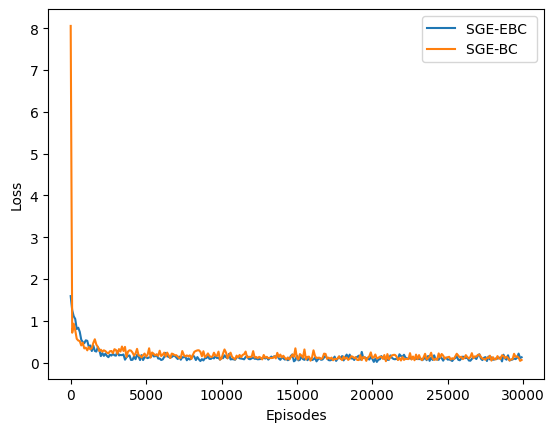

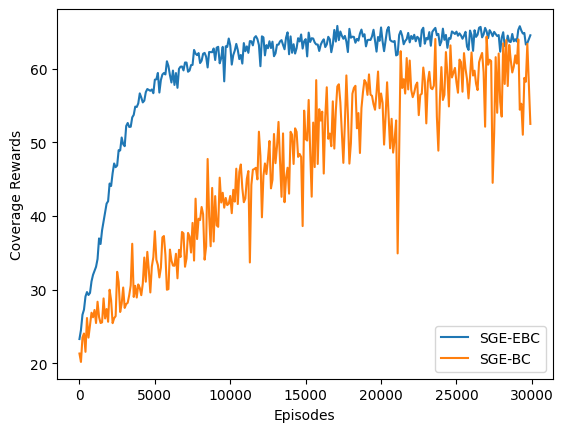

In [101]:
import pickle
import matplotlib.pyplot as plt

# 每100步采样一次
sampling_interval = 100
sampled_indices = range(0, len(ebc_loss_returns), sampling_interval)

# 对数据进行采样
ebc_sampled = [ebc_loss_returns[i] for i in sampled_indices]
bc_sampled = [bc_loss_returns[i] for i in sampled_indices]

# 绘图
plt.plot(sampled_indices, ebc_sampled, label='SGE-EBC ')
plt.plot(sampled_indices, bc_sampled, label='SGE-BC ')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.show()

plt.plot(sampled_indices,ebc_test_returns, label='SGE-EBC')
plt.plot(sampled_indices,bc_test_returns, label='SGE-BC')
plt.xlabel('Episodes')
plt.ylabel('Coverage Rewards')
plt.title('')
plt.legend()  # 显示图例
plt.show()

In [40]:

#评估函数
def evaluate_policy(model, states, actions):
    model.eval()
    with torch.no_grad():
        logits = model(states)
        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == actions).float().mean().item()
    print(f"Evaluation Accuracy: {accuracy*100:.2f}%")
    return accuracy
#保存模型
def save_policy_model(model, filepath="policy_model.pt"):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")
#加载模型
def load_policy_model(filepath, input_dim, hidden_dim, output_dim):
    model = PolicyNetwork(input_dim, hidden_dim, output_dim)
    model.load_state_dict(torch.load(filepath))
    model.eval()
    return model
#状态预测函数
def predict_action(model, states_tensor):
    """
    state_tensor: shape [1, D] 或 [D]
    """
    model.eval()
    actions=[]
    probss=[]
    for i in range(len(states_tensor)):
        # if states_tensor[i] < 0:
        #     states_tensor[i] = 0
        state_tensor = states_tensor[i]
        if state_tensor.dim() == 1:
            state_tensor = state_tensor.unsqueeze(0)
        with torch.no_grad():
            logits = model(state_tensor)
            probs = torch.softmax(logits, dim=1)
            action = torch.argmax(probs, dim=1).item()
            actions.append(action)
            probss.append(probs.squeeze().tolist())
    return actions, probss

def predict_action_batch(model, state_batch):
    """
    输入:
        state_batch: Tensor[N, D]，多个状态向量组成的 batch
    输出:
        actions: List[int]，每个状态对应的预测动作
        probs: List[List[float]]，每个状态的动作概率分布
    """
    model.eval()
    if state_batch.dim() == 1:
        state_batch = state_batch.unsqueeze(0)

    with torch.no_grad():
        logits = model(state_batch)
        probs = torch.softmax(logits, dim=1)
        actions = torch.argmax(probs, dim=1).tolist()
    return actions, probs.tolist()




In [17]:
def trajectory_to_temporal_states(batch_trajectory, temporal_encoder):
    """
    输入:
        batch_trajectory: Tensor[B, 40]
        temporal_encoder: TemporalStateEncoder 实例
    输出:
        Tensor[B, D]  # 每个轨迹编码后的向量
    """
    batch_embeddings = []
    for traj in batch_trajectory:
        traj = traj.tolist()
        vec = encode_temporal_state2(traj, temporal_encoder).detach()
        batch_embeddings.append(vec)
    return torch.stack(batch_embeddings)  # [B, D]